# Classez des images à l'aide d'algorithmes de Deep Learning

L'objectif de ce projet est d'entrainer un CNN capable de classer les images en fonction de la race du chien présent sur l'image, en utilisant notamment du Transfert Learning. 

Le dataset utilisé est le [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) .

Le dataset contient 120 races différentes.

Le but étant d'explorer les différentes options disponibles, d'apprendre à utiliser Keras, de modifier des structures existantes, de faire de l'optimisation d'hyperparamètres et du Fine Tuning, cela implique d'entrainer beaucoup de NN différents.

Afin de garder des temps d'entrainement raisonnables, et de pouvoir conserver toutes mes expérimentations dans un même Notebook, **je choisi de limiter arbitrairement le scope du projet à 10 classes/races**.

# Librairies

In [1]:
# Connecte le notebook Colab à Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://stackoverflow.com/questions/67360001/copy-files-from-a-mounted-google-drive-to-a-local-google-colab-session

In [2]:
# Import de librairies
import os, datetime
import warnings
warnings.filterwarnings("ignore")
import PIL
import PIL.Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.data import experimental
from tensorflow.keras.utils import plot_model, model_to_dot
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
!pip install -U keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 5.0 MB/s 


In [4]:
# tf version
print(tf.__version__)

2.8.2


In [5]:
# GPU utilisé dans l'instance colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jul 30 12:46:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# Verifie l'accessibilité du GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Import des données

In [7]:
# 10 premières races du dataset sélectionnées arbitrairement
class_list = ["n02085620-Chihuahua", 
              "n02085782-Japanese_spaniel", 
              "n02085936-Maltese_dog", 
              "n02086079-Pekinese", 
              "n02086240-Shih-Tzu",
              "n02086646-Blenheim_spaniel",
              "n02086910-papillon",
              "n02087046-toy_terrier",
              "n02087394-Rhodesian_ridgeback",
              "n02088094-Afghan_hound"
              ]

In [8]:
# Nombre de classes
num_class = len(class_list)

In [9]:
# Paramètre d'imports des images par Keras
data_dir = '/content/drive/My Drive/PStanford/data/images/Images'
img_height = 224
img_width = 224
channels = 3
batch_size = 32
array_size= img_width * img_height * channels

224*224 est l'imput recommandé de VGG16:

https://keras.io/api/applications/vgg/

# Training "from scratch" (sans transfert learning)

## Split training et validation

Le split entre le set de training et de la validation est effectué avec les ImageDataGenerator qui permettent de charger les images par batch et ne saturent pas la RAM/VRAM.

Fixer la random seed des ImageDataGenerator permet d'obternir les mêmes sets (sans overlapping) d'un ImageDataGenerator à un autre, afin de conserver les mêmes sets pour chaque entrainement.

- training set: 1540 images, 80% du dataset
- validation set: 379 image, 20% du dataset

## VGG16

Je choisi de commencer mes expérimentations en recérant "from scratch" une architecture éprouvée, **VGG16**, avec initiation random des poids.

### VGG16 standard

In [ ]:
# import et resize des images
datagen = ImageDataGenerator(validation_split=0.2
                             )

In [ ]:
train_generator = datagen.flow_from_directory(data_dir,
                                              target_size=(img_height,img_width),
                                              batch_size=batch_size,
                                              class_mode="categorical",
                                              classes=class_list,
                                              subset="training",
                                              seed=42,
                                              shuffle=False
                                              )



Found 1540 images belonging to 10 classes.


In [ ]:
val_generator = datagen.flow_from_directory(data_dir,
                                          target_size=(img_height,img_width),
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          classes=class_list,
                                          subset="validation",
                                          seed=42,
                                          shuffle=False
                                          )

Found 379 images belonging to 10 classes.


In [ ]:
# Construction du modèle
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=num_class, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

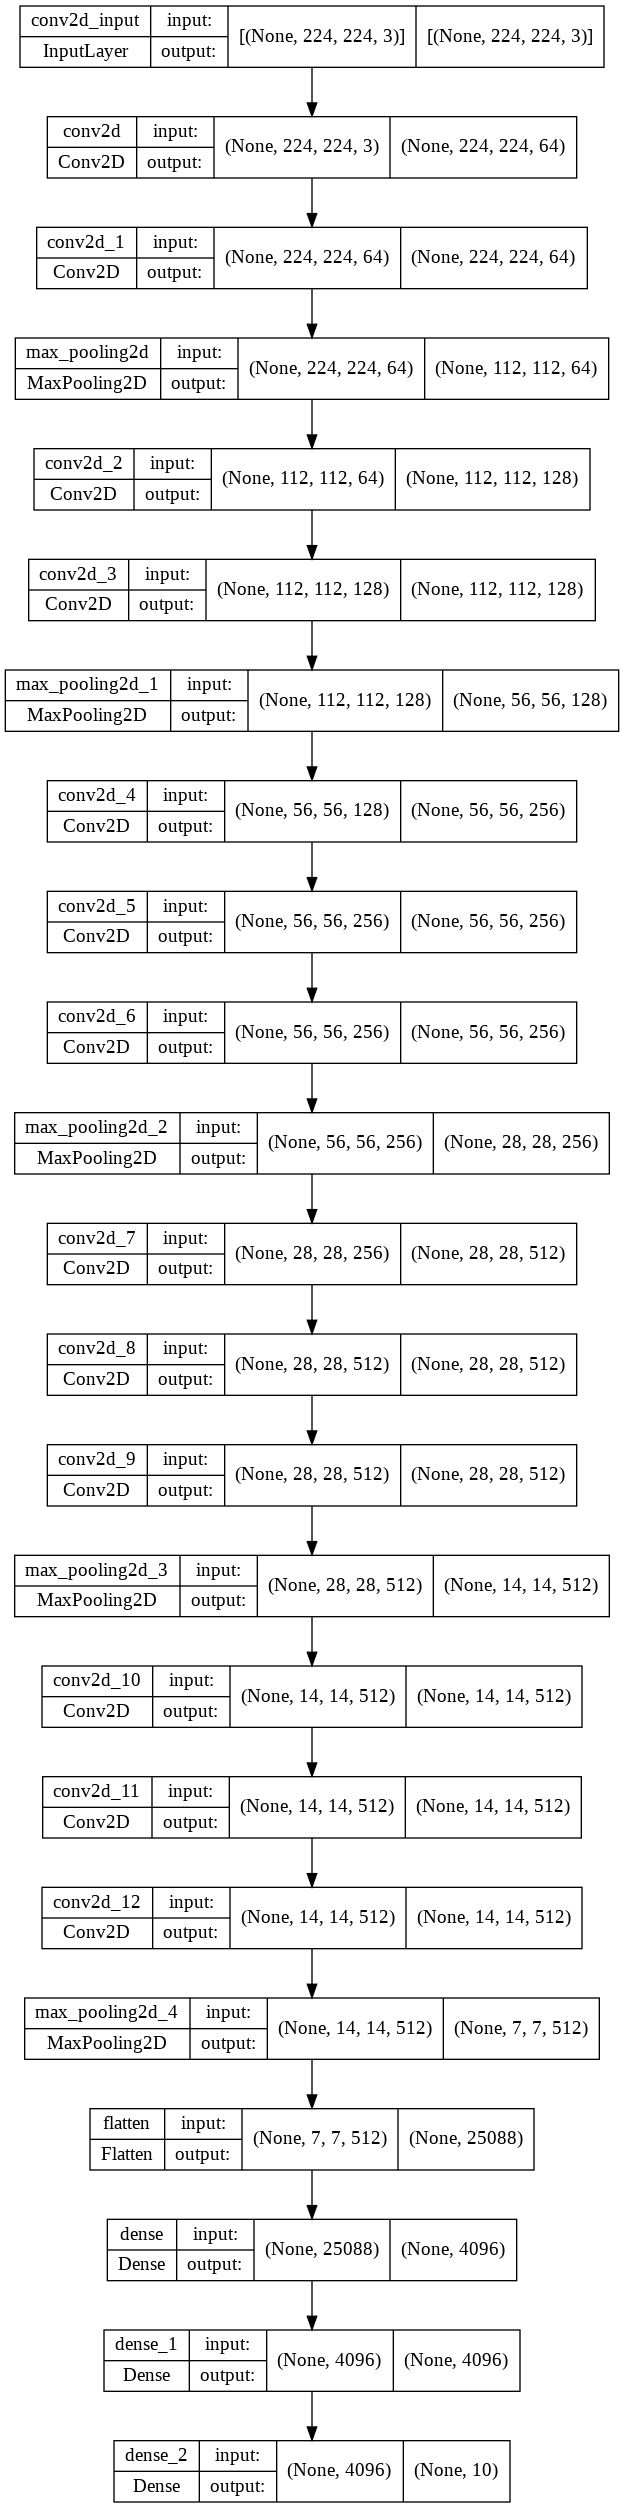

In [ ]:
# Displaying model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Définition de l'optimizer et du learning rate
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
%%time
# training
checkpoint = ModelCheckpoint("", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=10, 
                      verbose=1, 
                      mode='auto')

hist = model.fit(train_generator, 
                 validation_data=val_generator, 
                 epochs=50, 
                 callbacks=[checkpoint,early])

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 9210.4014 - accuracy: 0.0500 
Epoch 1: val_accuracy improved from -inf to 0.13193, saving model to 
INFO:tensorflow:Assets written to: assets
49/49 [==============================] - 723s 15s/step - loss: 9210.4014 - accuracy: 0.0500 - val_loss: 2.3003 - val_accuracy: 0.1319
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 2.3049 - accuracy: 0.0831
Epoch 2: val_accuracy did not improve from 0.13193
49/49 [==============================] - 14s 273ms/step - loss: 2.3049 - accuracy: 0.0831 - val_loss: 2.2985 - val_accuracy: 0.1240
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 2.3014 - accuracy: 0.1247
Epoch 3: val_accuracy did not improve from 0.13193
49/49 [==============================] - 13s 273ms/step - loss: 2.3014 - accuracy: 0.1247 - val_loss: 2.2975 - val_accuracy: 0.1240
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 2.3003 - accuracy: 0.1247
Epoch 4:

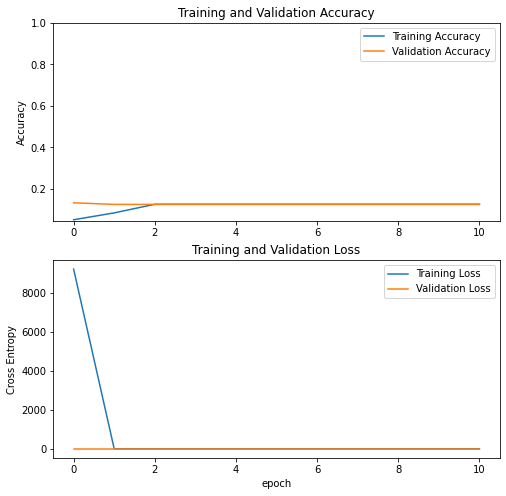

In [ ]:
# Plots des accuracy et cross entropy pour les sets de training et de validation par epoch
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Le NN n'apprend pas (peu importe le nombre d'epochs).

Le nombre d'images du set d'entrainement étant très faible (1540 pour 10 classes), il fait sens d'utiliser des méthodes de Data Augmentation.

nb. On considère comme "rule of thumb" qu'il faut une observation par paramètre entrainable (~134 millions) pour obtenir des performances satisfaisantes.

### avec Image Augmentation

Visualisons un sélection des différentes augmentations d'images possibles:

#### Visualisation des méthodes de Data Augmentation d'images

In [ ]:
def visualize_augmentation():
  
  train_generator = datagen.flow_from_directory(data_dir,
                                              target_size=(img_height,img_width),
                                              batch_size=1,
                                              class_mode="categorical",
                                              subset="training",
                                              seed=123
                                              )
  
  batch=next(train_generator)

  print(batch[0].shape) # batch[0] is the images, batch[1] are the labels
  img=batch[0][0]   # this is the first image  batch[0][1] would be the next image
  print(img.shape)
  plt.imshow(img)   # shows the first image
  


##### Zooms

In [ ]:
datagen = ImageDataGenerator(zoom_range=[0.5,1.5], rescale = 1./255)

Found 20580 images belonging to 120 classes.
(1, 224, 224, 3)
(224, 224, 3)


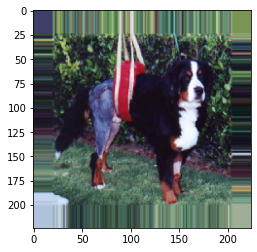

In [ ]:
visualize_augmentation()

##### Rotations

In [ ]:
datagen = ImageDataGenerator(rotation_range=90, rescale = 1./255)

Found 20580 images belonging to 120 classes.
(1, 224, 224, 3)
(224, 224, 3)


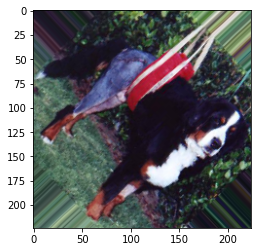

In [ ]:
visualize_augmentation()

##### Shifts


In [ ]:
datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, rescale = 1./255)

Found 20580 images belonging to 120 classes.
(1, 224, 224, 3)
(224, 224, 3)


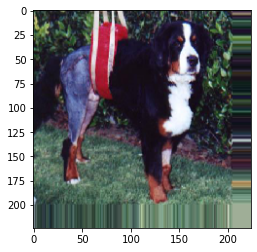

In [ ]:
visualize_augmentation()

##### Flips

In [ ]:
datagen = ImageDataGenerator(horizontal_flip=True, rescale = 1./255)

Found 20580 images belonging to 120 classes.
(1, 224, 224, 3)
(224, 224, 3)


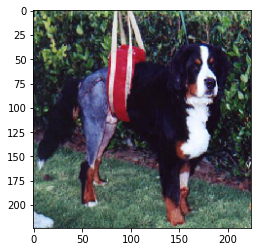

In [ ]:
visualize_augmentation()

##### Brightness

In [ ]:
datagen = ImageDataGenerator(brightness_range=[0.4,1.8], rescale = 1./255)

Found 20580 images belonging to 120 classes.
(1, 224, 224, 3)
(224, 224, 3)


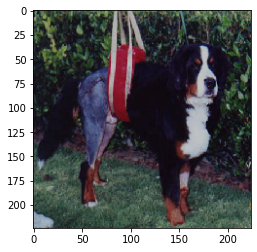

In [ ]:
visualize_augmentation()

#### Training

Application de la Data Augmentation à l'aide d'ImageDataGenerator, et retraining de l'achitecture précédente (VGG16 from scratch).

In [ ]:
# import des images, rezise et data augmentation
train_datagen = ImageDataGenerator(validation_split=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.2, height_shift_range=0.2,
                                  rotation_range=90,
                                  zoom_range=0.2,
                                  brightness_range=[0.4,1.8]
                                  )

In [ ]:
val_datagen = ImageDataGenerator(validation_split=0.2
                                )

In [ ]:
train_generator = train_datagen.flow_from_directory(data_dir,
                                              target_size=(img_height,img_width),
                                              batch_size=batch_size,
                                              class_mode="categorical",
                                              classes=class_list,
                                              subset="training",
                                              seed=42,
                                              shuffle=False
                                              )



Found 1540 images belonging to 10 classes.


In [ ]:
val_generator = val_datagen.flow_from_directory(data_dir,
                                          target_size=(img_height,img_width),
                                          #batch_size=batch_size,
                                          class_mode='categorical',
                                          classes=class_list,
                                          subset="validation",
                                          seed=42,
                                          shuffle=False
                                          )

Found 379 images belonging to 10 classes.


In [ ]:
# Construction du modèle
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=num_class, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

In [ ]:
# Définition de l'optimizer et du learning rate
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
%%time
# training
checkpoint = ModelCheckpoint("", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=10, 
                      verbose=1, 
                      mode='auto')

hist = model.fit(train_generator, 
                 validation_data=val_generator, 
                 epochs=50, 
                 callbacks=[checkpoint,early])

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 938.1398 - accuracy: 0.0623
Epoch 1: val_accuracy improved from -inf to 0.12401, saving model to 
INFO:tensorflow:Assets written to: assets
49/49 [==============================] - 40s 804ms/step - loss: 938.1398 - accuracy: 0.0623 - val_loss: 2.3002 - val_accuracy: 0.1240
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 2.3040 - accuracy: 0.0831
Epoch 2: val_accuracy did not improve from 0.12401
49/49 [==============================] - 30s 605ms/step - loss: 2.3040 - accuracy: 0.0831 - val_loss: 2.2983 - val_accuracy: 0.1240
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 2.3016 - accuracy: 0.1065
Epoch 3: val_accuracy did not improve from 0.12401
49/49 [==============================] - 30s 604ms/step - loss: 2.3016 - accuracy: 0.1065 - val_loss: 2.2974 - val_accuracy: 0.1240
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 2.3027 - accuracy: 0.1247
Epoch 4: v

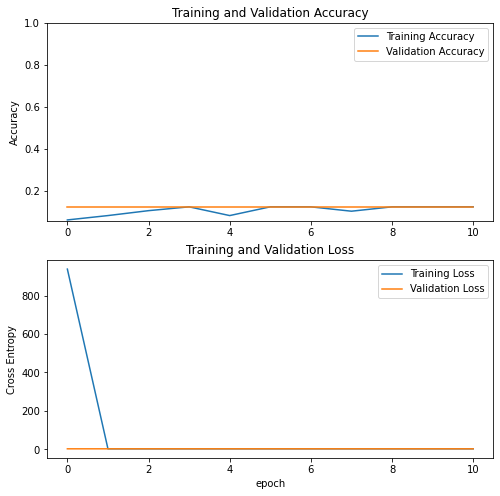

In [ ]:
# Plots des accuracy et cross entropy pour les sets de training et de validation par epoch
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Le modèle n'apprend toujours pas.

### avec Batch normalization & Dropout

Expérimentons l'ajout de couches supplémentaires à l'architecture VGG16 from scratch.

Ajout de couches de Batchnormalization: 
- Permet de réduire l'overfitting et un entrainement plus rapide
- Habituellement insérées après des couches denses ou convolutionelles.

Ajout de couches de droupout, également pour réduire l'overfitting.

In [ ]:
# Construction du modèle
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization()) ### Ajout
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization()) ### Ajout
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization()) ### Ajout
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization()) ### Ajout
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(BatchNormalization()) ### Ajout
model.add(Dropout(0.5)) ### Ajout
model.add(Dense(units=4096,activation="relu"))
model.add(BatchNormalization()) ### Ajout
model.add(Dropout(0.5)) ### Ajout
model.add(Dense(units=num_class, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_27 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_29 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 128)    512       
 ormalization)                                        

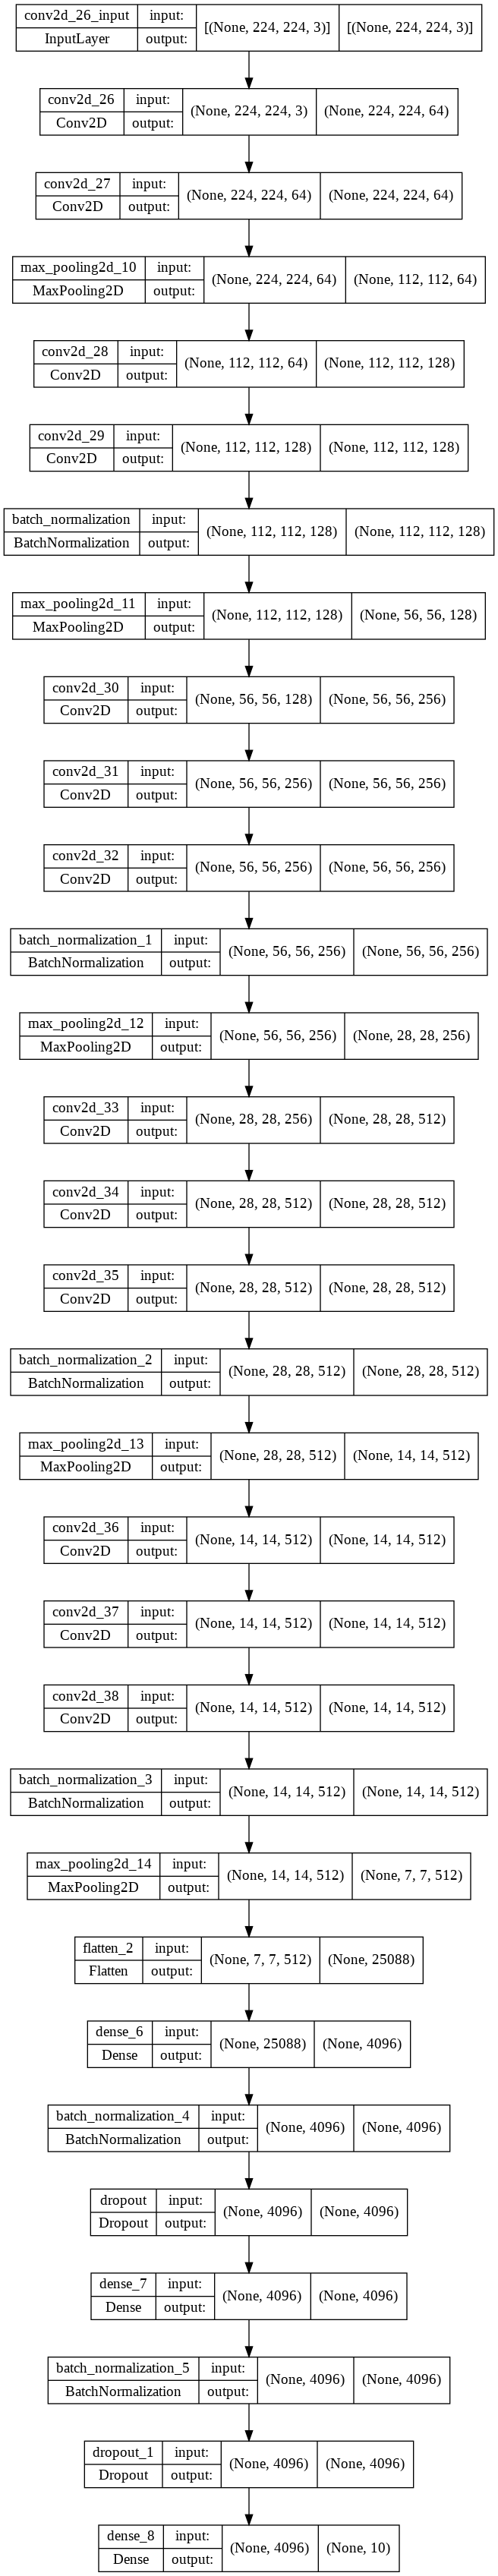

In [ ]:
# Displaying model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Définition de l'optimizer et du learning rate
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
%%time
# training
checkpoint = ModelCheckpoint("", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=10, 
                      verbose=1, 
                      mode='auto')

hist = model.fit(train_generator, 
                 validation_data=val_generator, 
                 epochs=50, 
                 callbacks=[checkpoint,early])

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 3.7902 - accuracy: 0.1039
Epoch 1: val_accuracy improved from -inf to 0.08971, saving model to 
INFO:tensorflow:Assets written to: assets
49/49 [==============================] - 48s 936ms/step - loss: 3.7902 - accuracy: 0.1039 - val_loss: 1135.4672 - val_accuracy: 0.0897
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 3.3752 - accuracy: 0.0935
Epoch 2: val_accuracy improved from 0.08971 to 0.11873, saving model to 
INFO:tensorflow:Assets written to: assets
49/49 [==============================] - 40s 810ms/step - loss: 3.3752 - accuracy: 0.0935 - val_loss: 41.8116 - val_accuracy: 0.1187
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 3.2711 - accuracy: 0.0994
Epoch 3: val_accuracy did not improve from 0.11873
49/49 [==============================] - 30s 605ms/step - loss: 3.2711 - accuracy: 0.0994 - val_loss: 9.0618 - val_accuracy: 0.1108
Epoch 4/50
49/49 [======================

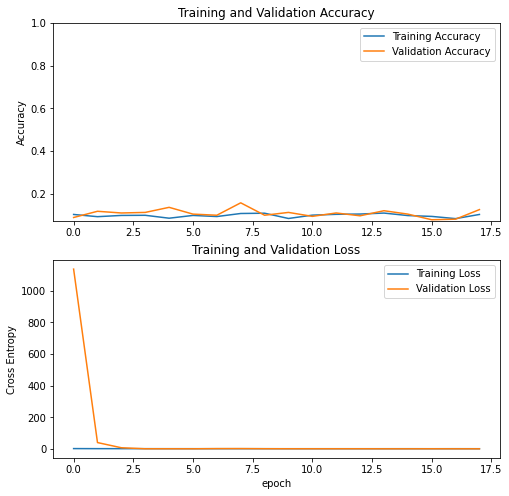

In [ ]:
# Plots des accuracy et cross entropy pour les sets de training et de validation par epoch
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
hist.history['val_accuracy'][-1]

0.12664908170700073

### avec RMSprop à la place d'Adam

Essayons de changer l'optimizer (Adam) pour RMSprop dans l'architecture précédente

In [ ]:
# Construction du modèle
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization()) ### Ajout
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization()) ### Ajout
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization()) ### Ajout
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization()) ### Ajout
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(BatchNormalization()) ### Ajout
model.add(Dropout(0.5)) ### Ajout
model.add(Dense(units=4096,activation="relu"))
model.add(BatchNormalization()) ### Ajout
model.add(Dropout(0.5)) ### Ajout
model.add(Dense(units=num_class, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_40 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_42 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 batch_normalization_6 (Batc  (None, 112, 112, 128)    512       
 hNormalization)                                      

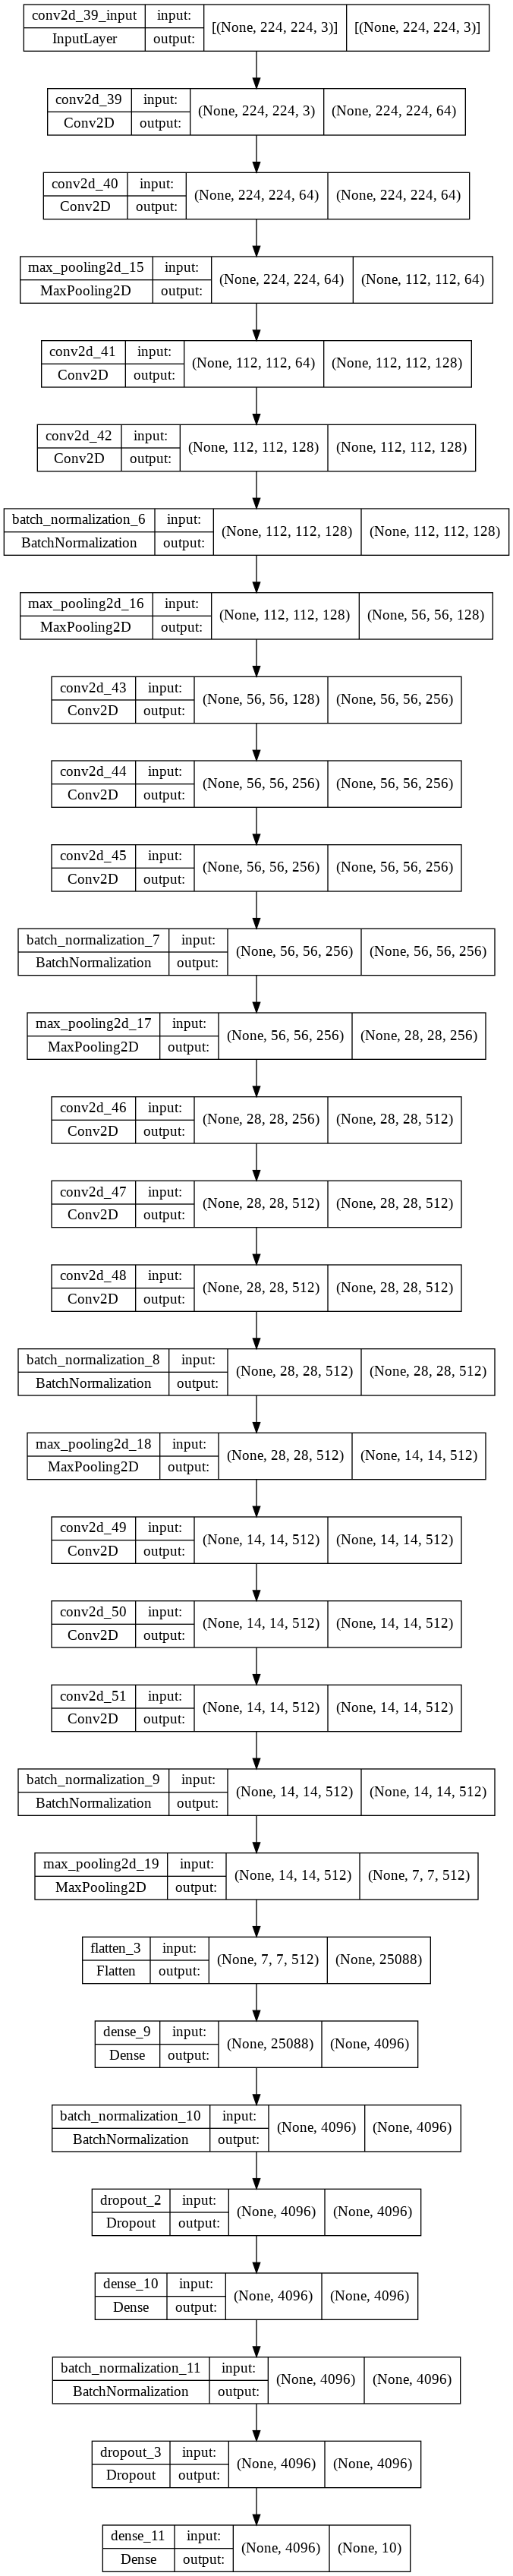

In [ ]:
# Displaying model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Définition de l'optimizer et du learning rate
opt = RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
%%time
# training
checkpoint = ModelCheckpoint("", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=10, 
                      verbose=1, 
                      mode='auto')

hist = model.fit(train_generator, 
                 validation_data=val_generator, 
                 epochs=50, 
                 callbacks=[checkpoint,early])

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 4.9679 - accuracy: 0.1026
Epoch 1: val_accuracy improved from -inf to 0.11346, saving model to 
INFO:tensorflow:Assets written to: assets
49/49 [==============================] - 41s 777ms/step - loss: 4.9679 - accuracy: 0.1026 - val_loss: 16.9639 - val_accuracy: 0.1135
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 3.9222 - accuracy: 0.0883
Epoch 2: val_accuracy did not improve from 0.11346
49/49 [==============================] - 31s 624ms/step - loss: 3.9222 - accuracy: 0.0883 - val_loss: 17.8823 - val_accuracy: 0.0897
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 3.9350 - accuracy: 0.0864
Epoch 3: val_accuracy did not improve from 0.11346
49/49 [==============================] - 30s 617ms/step - loss: 3.9350 - accuracy: 0.0864 - val_loss: 4.1908 - val_accuracy: 0.0765
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 3.6348 - accuracy: 0.1097
Epoch 4: val

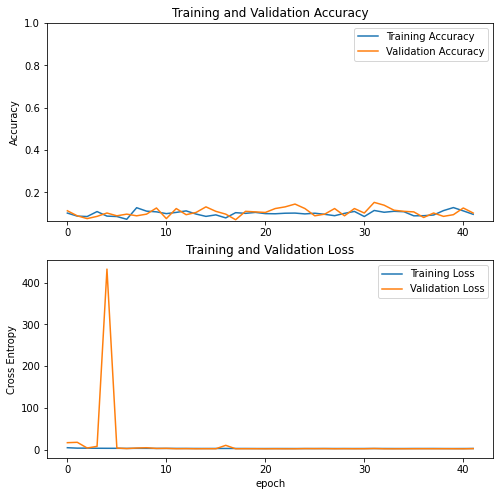

In [ ]:
# Plots des accuracy et cross entropy pour les sets de training et de validation par epoch
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Le modèle n'apprend toujours pas.

### avec de plus grands kernels de convolution
Reprenons l'architecture précédente avec Adam comme optimizer, et essayons de plus grands kernels (5x5 au lieu de 3x3).

In [ ]:
# Construction du modèle
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(5,5),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(5,5),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(5,5), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(5,5), padding="same", activation="relu"))
model.add(BatchNormalization()) ### Ajout
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(5,5), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(5,5), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(5,5), padding="same", activation="relu"))
model.add(BatchNormalization()) ### Ajout
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(5,5), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(5,5), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(5,5), padding="same", activation="relu"))
model.add(BatchNormalization()) ### Ajout
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(5,5), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(5,5), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(5,5), padding="same", activation="relu"))
model.add(BatchNormalization()) ### Ajout
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(BatchNormalization()) ### Ajout
model.add(Dropout(0.5)) ### Ajout
model.add(Dense(units=4096,activation="relu"))
model.add(BatchNormalization()) ### Ajout
model.add(Dropout(0.5)) ### Ajout
model.add(Dense(units=num_class, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 224, 224, 64)      4864      
                                                                 
 conv2d_53 (Conv2D)          (None, 224, 224, 64)      102464    
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 112, 112, 128)     204928    
                                                                 
 conv2d_55 (Conv2D)          (None, 112, 112, 128)     409728    
                                                                 
 batch_normalization_12 (Bat  (None, 112, 112, 128)    512       
 chNormalization)                                     

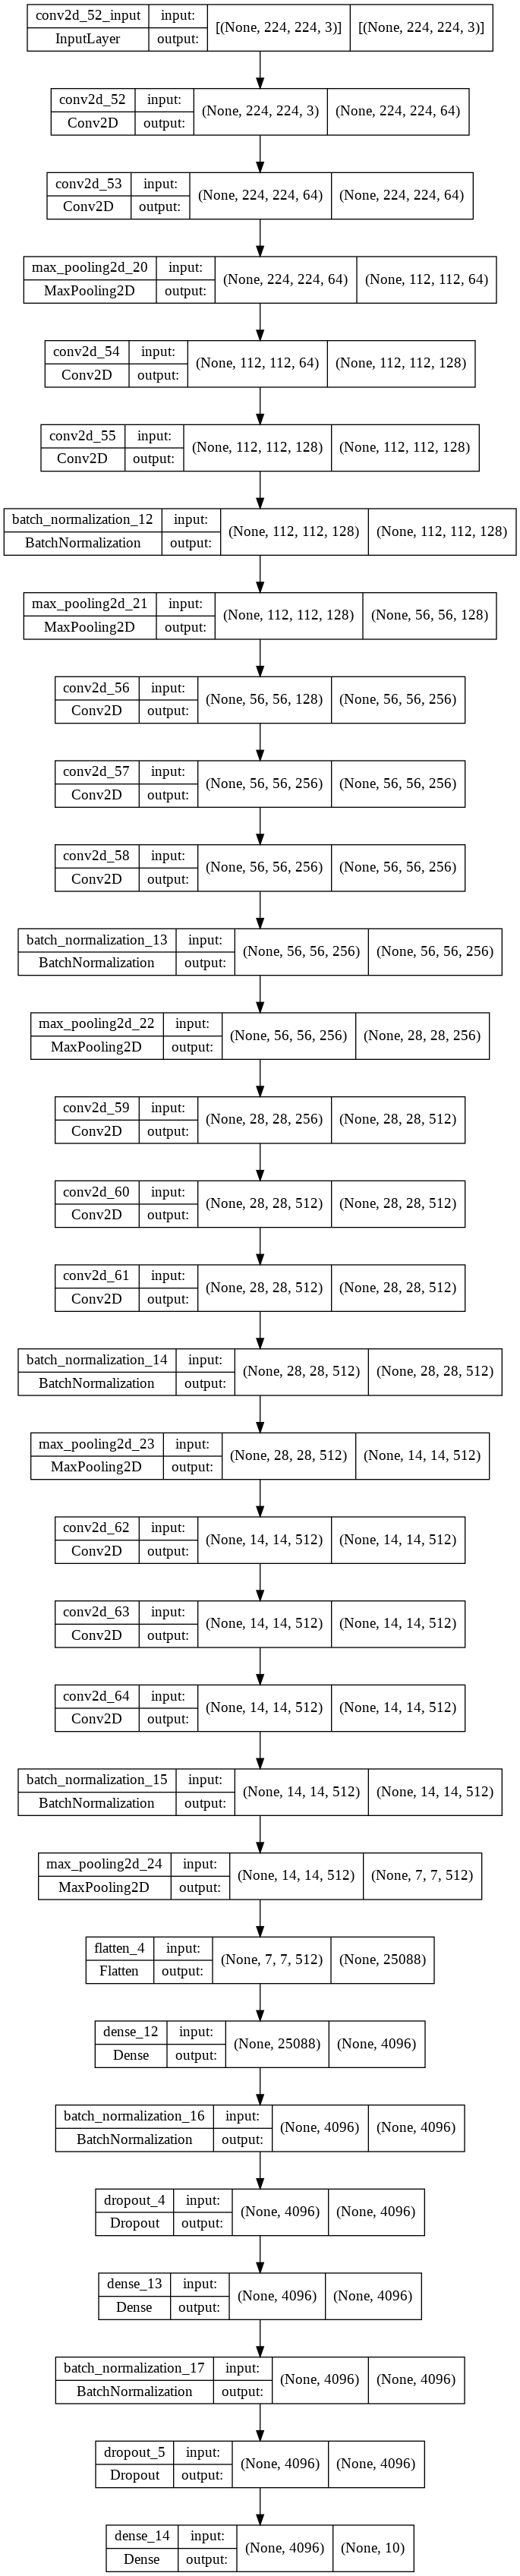

In [ ]:
# Displaying model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Définition de l'optimizer et du learning rate
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
%%time
# training
checkpoint = ModelCheckpoint("", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=10, 
                      verbose=1, 
                      mode='auto')

hist = model.fit(train_generator, 
                 validation_data=val_generator, 
                 epochs=50, 
                 callbacks=[checkpoint,early])

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 3.6820 - accuracy: 0.0974
Epoch 1: val_accuracy improved from -inf to 0.07916, saving model to 
INFO:tensorflow:Assets written to: assets
49/49 [==============================] - 55s 1s/step - loss: 3.6820 - accuracy: 0.0974 - val_loss: 1329.6721 - val_accuracy: 0.0792
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 3.2277 - accuracy: 0.1156
Epoch 2: val_accuracy improved from 0.07916 to 0.08707, saving model to 
INFO:tensorflow:Assets written to: assets
49/49 [==============================] - 44s 902ms/step - loss: 3.2277 - accuracy: 0.1156 - val_loss: 12.1057 - val_accuracy: 0.0871
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 3.2285 - accuracy: 0.1097
Epoch 3: val_accuracy improved from 0.08707 to 0.11346, saving model to 
INFO:tensorflow:Assets written to: assets
49/49 [==============================] - 44s 890ms/step - loss: 3.2285 - accuracy: 0.1097 - val_loss: 6.8888 - 

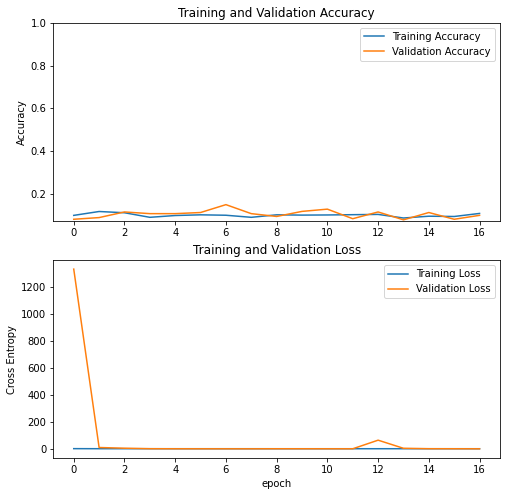

In [ ]:
# Plots des accuracy et cross entropy pour les sets de training et de validation par epoch
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
hist.history['val_accuracy'][-1]

0.09762533009052277

Le modèle n'apprend toujours pas.

## ResNet50

Essayons de charger une autre architecture depuis Keras, ResNet50, toujours en initiant les poids aléatoirement.

In [10]:
# import des images, rezise et data augmentation
train_datagen = ImageDataGenerator(validation_split=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.2, height_shift_range=0.2,
                                  rotation_range=90,
                                  zoom_range=[0.5,1.5],
                                  brightness_range=[0.4,1.8],
                                  preprocessing_function=tf.keras.applications.resnet50.preprocess_input
                                  )

In [11]:
val_datagen = ImageDataGenerator(validation_split=0.2,
                                 preprocessing_function=tf.keras.applications.resnet50.preprocess_input
                                )

In [12]:
train_generator = train_datagen.flow_from_directory(data_dir,
                                              target_size=(img_height,img_width),
                                              batch_size=batch_size,
                                              class_mode="categorical",
                                              classes=class_list,
                                              subset="training",
                                              seed=42,
                                              shuffle=False
                                              )



Found 1540 images belonging to 10 classes.


In [13]:
val_generator = val_datagen.flow_from_directory(data_dir,
                                          target_size=(img_height,img_width),
                                          #batch_size=batch_size,
                                          class_mode='categorical',
                                          classes=class_list,
                                          subset="validation",
                                          seed=42,
                                          shuffle=False
                                          )

Found 379 images belonging to 10 classes.


In [14]:
# Construction du modèle
model = Sequential()

model.add(tf.keras.applications.ResNet50(include_top=False, input_shape=(img_width,img_height,3), pooling='avg', weights=None))
model.add(Flatten())
model.add(Dense(num_class, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [16]:
# Définition de l'optimizer et du learning rate
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [17]:
%%time
# training
checkpoint = ModelCheckpoint("", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=10, 
                      verbose=1, 
                      mode='auto')

hist = model.fit(train_generator, 
                 validation_data=val_generator, 
                 epochs=50, 
                 callbacks=[checkpoint,early])

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 3.6717 - accuracy: 0.0604
Epoch 1: val_accuracy improved from -inf to 0.11609, saving model to 
INFO:tensorflow:Assets written to: assets
49/49 [==============================] - 428s 8s/step - loss: 3.6717 - accuracy: 0.0604 - val_loss: 429.2636 - val_accuracy: 0.1161
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 2.6246 - accuracy: 0.1078
Epoch 2: val_accuracy did not improve from 0.11609
49/49 [==============================] - 30s 620ms/step - loss: 2.6246 - accuracy: 0.1078 - val_loss: 37.8880 - val_accuracy: 0.0686
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 2.5967 - accuracy: 0.0513
Epoch 3: val_accuracy improved from 0.11609 to 0.14248, saving model to 
INFO:tensorflow:Assets written to: assets
49/49 [==============================] - 54s 1s/step - loss: 2.5967 - accuracy: 0.0513 - val_loss: 2.3021 - val_accuracy: 0.1425
Epoch 4/50
49/49 [============================

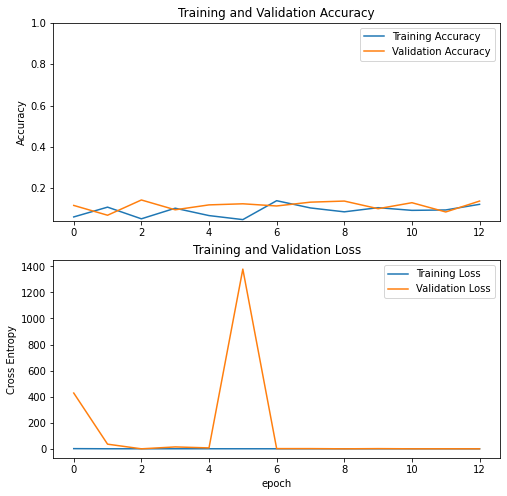

In [18]:
# Plots des accuracy et cross entropy pour les sets de training et de validation par epoch
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
hist.history['val_accuracy'][-1]

0.09762533009052277

De manière prévisible, ResNet sans transfert learning n'apprend pas non plus.

# Transfert Learning

Essayons maintenant la manière la plus courante d'entrainer des CNN, à l'aide de transfert learning.

Il faut également expérimenter plusieurs architectures et hyperparamètres pour les couches supérieures (non pré-entrainées).

## ResNet50

Reprenons l'architecture ResNet50 essayée juste avant, cette fois en chargant les poids avec l'architecture. (modèle/poids préentrainé sur imagenet)

In [ ]:
# import des images, rezise et data augmentation
train_datagen = ImageDataGenerator(validation_split=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.2, height_shift_range=0.2,
                                  rotation_range=90,
                                  zoom_range=[0.5,1.5],
                                  brightness_range=[0.4,1.8],
                                  preprocessing_function=tf.keras.applications.resnet50.preprocess_input
                                  )

In [ ]:
val_datagen = ImageDataGenerator(validation_split=0.2,
                                 preprocessing_function=tf.keras.applications.resnet50.preprocess_input
                                )

In [ ]:
train_generator = train_datagen.flow_from_directory(data_dir,
                                              target_size=(img_height,img_width),
                                              batch_size=batch_size,
                                              class_mode="categorical",
                                              classes=class_list,
                                              subset="training",
                                              seed=42,
                                              shuffle=False
                                              )



Found 1540 images belonging to 10 classes.


In [ ]:
val_generator = val_datagen.flow_from_directory(data_dir,
                                          target_size=(img_height,img_width),
                                          #batch_size=batch_size,
                                          class_mode='categorical',
                                          classes=class_list,
                                          subset="validation",
                                          seed=42,
                                          shuffle=False
                                          )

Found 379 images belonging to 10 classes.


### 3 couches denses

On ajoute 3 couches denses à la suite des couches préentrainées, dont on bloque l'update/entrainement des poids.

Je porte mon choix sur un nombre d'units de 1024 et 512  pour les deux premières couches ajoutées, choix effectué après plusieurs essais (peu d'influence du nombre d'units, bon rapport performance/nombre de poids à entrainer).
Fonction d'activation: rectified linear activation function (ReLu); standard, entrainement plus rapide.

La dernière couche est une couche dense avec 10 units correspondant au nombre de classes/races. 
Fonction d'activation: Softmax; addition des probabilités de chaque classe = 1

In [ ]:
# Construction du modèle
model = Sequential()

model.add(tf.keras.applications.ResNet50(include_top=False, input_shape=(img_width,img_height,3), pooling='avg', weights='imagenet'))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(num_class, activation='softmax'))

model.layers[0].trainable = False

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_16 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_17 (Dense)            (None, 512)               524800    
                                                                 
 dense_18 (Dense)            (None, 10)                5130      
                                                                 
Total params: 26,215,818
Trainable params: 2,628,106
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
# Définition de l'optimizer et du learning rate
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
%%time
# training
checkpoint = ModelCheckpoint("", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=10, 
                      verbose=1, 
                      mode='auto')

hist = model.fit(train_generator, 
                 validation_data=val_generator, 
                 epochs=50, 
                 callbacks=[checkpoint,early])

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 2.4246 - accuracy: 0.2078
Epoch 1: val_accuracy improved from -inf to 0.60422, saving model to 
INFO:tensorflow:Assets written to: assets
49/49 [==============================] - 63s 1s/step - loss: 2.4246 - accuracy: 0.2078 - val_loss: 1.3464 - val_accuracy: 0.6042
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 1.6282 - accuracy: 0.4714
Epoch 2: val_accuracy improved from 0.60422 to 0.76517, saving model to 
INFO:tensorflow:Assets written to: assets
49/49 [==============================] - 54s 1s/step - loss: 1.6282 - accuracy: 0.4714 - val_loss: 0.9016 - val_accuracy: 0.7652
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 1.2991 - accuracy: 0.5643
Epoch 3: val_accuracy improved from 0.76517 to 0.76781, saving model to 
INFO:tensorflow:Assets written to: assets
49/49 [==============================] - 53s 1s/step - loss: 1.2991 - accuracy: 0.5643 - val_loss: 0.7302 - val_accura

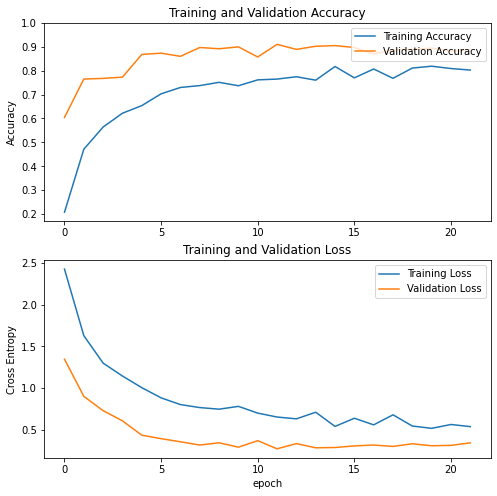

In [ ]:
# Plots des accuracy et cross entropy pour les sets de training et de validation par epoch
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Le modèle apprend, la différence est très marquée dès la première epoch avec des performances beaucoup plus élevée (au regard de l'accuracy sur le test set).

On remarque cependant de l'overfitting sur le set de training.

### ajout dropout

Ajoutons des couches de dropout pour limiter le surapprentissage.

In [ ]:
# Construction du modèle
model = Sequential()

model.add(tf.keras.applications.ResNet50(include_top=False, input_shape=(img_width,img_height,3), pooling='avg', weights='imagenet'))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_class, activation='softmax'))

model.layers[0].trainable = False

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 dense_19 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_20 (Dense)            (None, 512)               524800    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 10)               

In [ ]:
# Définition de l'optimizer et du learning rate
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
# training
checkpoint = ModelCheckpoint("", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=10, 
                      verbose=1, 
                      mode='auto')

hist = model.fit(train_generator, 
                 validation_data=val_generator, 
                 epochs=50, 
                 callbacks=[checkpoint,early])

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 3.2875 - accuracy: 0.1065
Epoch 1: val_accuracy improved from -inf to 0.48813, saving model to 
INFO:tensorflow:Assets written to: assets
49/49 [==============================] - 53s 1s/step - loss: 3.2875 - accuracy: 0.1065 - val_loss: 1.6963 - val_accuracy: 0.4881
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 2.1715 - accuracy: 0.2617
Epoch 2: val_accuracy improved from 0.48813 to 0.72559, saving model to 
INFO:tensorflow:Assets written to: assets
49/49 [==============================] - 49s 1s/step - loss: 2.1715 - accuracy: 0.2617 - val_loss: 1.2471 - val_accuracy: 0.7256
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 1.8932 - accuracy: 0.3532
Epoch 3: val_accuracy improved from 0.72559 to 0.75462, saving model to 
INFO:tensorflow:Assets written to: assets
49/49 [==============================] - 49s 1s/step - loss: 1.8932 - accuracy: 0.3532 - val_loss: 0.9750 - val_accura

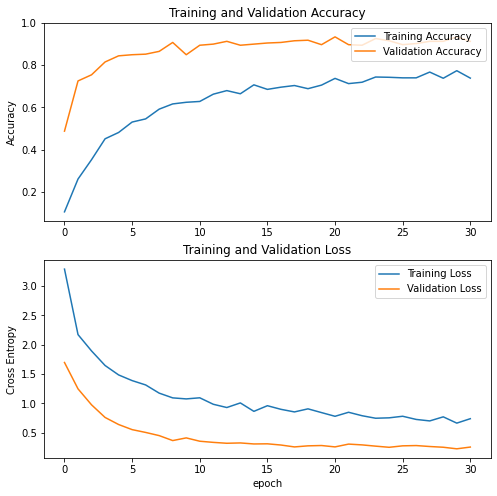

In [ ]:
# Plots des accuracy et cross entropy pour les sets de training et de validation par epoch
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

L'ajout de couches de dropout semble offrir l'effet escompté.

**Après plusieurs essais manuels, je choisi de garder ces mêmes couches supérieures et hyperparamètres pour les modèles suivants.**

## VGG16

Essayons maintenant VGG16 préentrainé, en utilisant la même methode qu'avec ResNet50:
- poids préentrainés non-trainables
- suivi de 2 couches denses
- suivies chacune d'une couche de dropout
- 1 couche de sortie (softmax)

In [ ]:
# import des images, rezise et data augmentation
train_datagen = ImageDataGenerator(validation_split=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.2, height_shift_range=0.2,
                                  rotation_range=90,
                                  zoom_range=[0.5,1.5],
                                  brightness_range=[0.4,1.8],
                                  preprocessing_function=tf.keras.applications.vgg16.preprocess_input
                                  )

In [ ]:
val_datagen = ImageDataGenerator(validation_split=0.2,
                                 preprocessing_function=tf.keras.applications.vgg16.preprocess_input
                                )

In [ ]:
train_generator = train_datagen.flow_from_directory(data_dir,
                                              target_size=(img_height,img_width),
                                              batch_size=batch_size,
                                              class_mode="categorical",
                                              classes=class_list,
                                              subset="training",
                                              seed=42,
                                              shuffle=False
                                              )



Found 1540 images belonging to 10 classes.


In [ ]:
val_generator = val_datagen.flow_from_directory(data_dir,
                                          target_size=(img_height,img_width),
                                          #batch_size=batch_size,
                                          class_mode='categorical',
                                          classes=class_list,
                                          subset="validation",
                                          seed=42,
                                          shuffle=False
                                          )

Found 379 images belonging to 10 classes.


In [ ]:
# Construction du modèle
model = Sequential()

model.add(tf.keras.applications.VGG16(include_top=False, input_shape=(img_width,img_height,3), pooling='avg', weights='imagenet'))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_class, activation='softmax'))

model.layers[0].trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_8 (Flatten)         (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 1024)              525312    
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_23 (Dense)            (None, 512)               524800    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 10)               

In [ ]:
# Définition de l'optimizer et du learning rate
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
# training
checkpoint = ModelCheckpoint("", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=10, 
                      verbose=1, 
                      mode='auto')

hist = model.fit(train_generator, 
                 validation_data=val_generator, 
                 epochs=50, 
                 callbacks=[checkpoint,early])

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 8.3709 - accuracy: 0.0929
Epoch 1: val_accuracy improved from -inf to 0.49604, saving model to 
INFO:tensorflow:Assets written to: assets
49/49 [==============================] - 32s 646ms/step - loss: 8.3709 - accuracy: 0.0929 - val_loss: 1.8147 - val_accuracy: 0.4960
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 5.0642 - accuracy: 0.2039
Epoch 2: val_accuracy improved from 0.49604 to 0.62797, saving model to 
INFO:tensorflow:Assets written to: assets
49/49 [==============================] - 33s 657ms/step - loss: 5.0642 - accuracy: 0.2039 - val_loss: 1.1652 - val_accuracy: 0.6280
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 3.8424 - accuracy: 0.2448
Epoch 3: val_accuracy improved from 0.62797 to 0.66227, saving model to 
INFO:tensorflow:Assets written to: assets
49/49 [==============================] - 34s 689ms/step - loss: 3.8424 - accuracy: 0.2448 - val_loss: 1.0726 - v

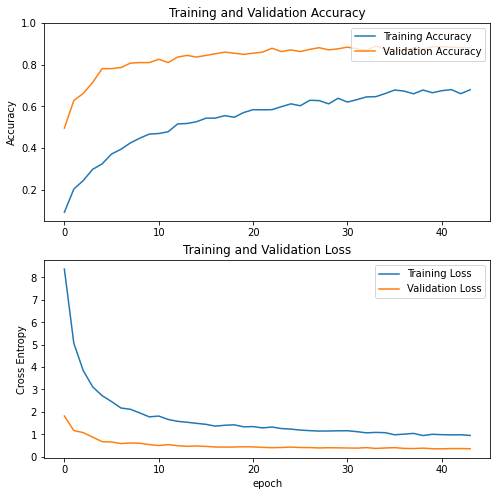

In [ ]:
# Plots des accuracy et cross entropy pour les sets de training et de validation par epoch
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Les résultats sont aussi remarquablement meilleurs grâce au transfert learning comparés au VGG16 avec initialisation aléatoire.

## Xception

Essayons Xception préentrainé, qui performe souvent mieux que les architectures essayées précédement.

Même methode qu'utilisée précédement:
- poids préentrainés non-trainables
- suivi de 2 couches denses
- suivies chacune d'une couche de dropout
- 1 couche de sortie (softmax)

In [ ]:
# import des images, rezise et data augmentation
train_datagen = ImageDataGenerator(validation_split=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.2, height_shift_range=0.2,
                                  rotation_range=90,
                                  zoom_range=[0.5,1.5],
                                  brightness_range=[0.4,1.8],
                                  preprocessing_function=tf.keras.applications.xception.preprocess_input
                                  )

In [ ]:
val_datagen = ImageDataGenerator(validation_split=0.2,
                                 preprocessing_function=tf.keras.applications.xception.preprocess_input
                                )

In [ ]:
train_generator = train_datagen.flow_from_directory(data_dir,
                                              target_size=(img_height,img_width),
                                              batch_size=batch_size,
                                              class_mode="categorical",
                                              classes=class_list,
                                              subset="training",
                                              seed=42,
                                              shuffle=False
                                              )



Found 1540 images belonging to 10 classes.


In [ ]:
val_generator = val_datagen.flow_from_directory(data_dir,
                                          target_size=(img_height,img_width),
                                          #batch_size=batch_size,
                                          class_mode='categorical',
                                          classes=class_list,
                                          subset="validation",
                                          seed=42,
                                          shuffle=False
                                          )

Found 379 images belonging to 10 classes.


In [ ]:
# Construction du modèle
model = Sequential()

model.add(tf.keras.applications.Xception(include_top=False, input_shape=(img_width,img_height,3), pooling='avg', weights='imagenet'))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_class, activation='softmax'))

model.layers[0].trainable = False

83697664/83683744 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_9 (Flatten)         (None, 2048)              0         
                                                                 
 dense_25 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_10 (Dropout)        (None, 1024)              0         
                                                                 
 dense_26 (Dense)            (None, 512)               524800    
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 10)               

In [ ]:
# Définition de l'optimizer et du learning rate
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
# training
checkpoint = ModelCheckpoint("", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=10, 
                      verbose=1, 
                      mode='auto')

hist = model.fit(train_generator, 
                 validation_data=val_generator, 
                 epochs=50, 
                 callbacks=[checkpoint,early])

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 2.4186 - accuracy: 0.1766
Epoch 1: val_accuracy improved from -inf to 0.78364, saving model to 
INFO:tensorflow:Assets written to: assets
49/49 [==============================] - 47s 915ms/step - loss: 2.4186 - accuracy: 0.1766 - val_loss: 1.5223 - val_accuracy: 0.7836
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 1.7688 - accuracy: 0.4338
Epoch 2: val_accuracy improved from 0.78364 to 0.84960, saving model to 
INFO:tensorflow:Assets written to: assets
49/49 [==============================] - 44s 900ms/step - loss: 1.7688 - accuracy: 0.4338 - val_loss: 0.8851 - val_accuracy: 0.8496
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 1.4303 - accuracy: 0.5513
Epoch 3: val_accuracy improved from 0.84960 to 0.87335, saving model to 
INFO:tensorflow:Assets written to: assets
49/49 [==============================] - 44s 901ms/step - loss: 1.4303 - accuracy: 0.5513 - val_loss: 0.5528 - v

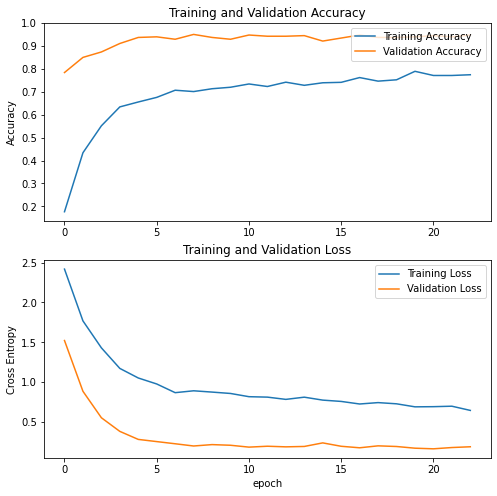

In [ ]:
# Plots des accuracy et cross entropy pour les sets de training et de validation par epoch
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Xception pré-entrainé semble offrir les meilleurs performances au regard de l'accuracy sur le test de validation.

# Hyperparameters Tuning

Essayons d'optimiser certains hyperparamètres du modèle pour gagner encore en performance.

Je choisi d'utiliser l'Hyperband tuner de Keras, car plus rapide que l'Optimisation Bayésienne. 

In [ ]:
# import des images, rezise et data augmentation
train_datagen = ImageDataGenerator(validation_split=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.2, height_shift_range=0.2,
                                  rotation_range=90,
                                  zoom_range=[0.5,1.5],
                                  brightness_range=[0.4,1.8],
                                  preprocessing_function=tf.keras.applications.xception.preprocess_input
                                  )

In [ ]:
val_datagen = ImageDataGenerator(validation_split=0.2,
                                 preprocessing_function=tf.keras.applications.xception.preprocess_input
                                )

In [ ]:
train_generator = train_datagen.flow_from_directory(data_dir,
                                              target_size=(img_height,img_width),
                                              batch_size=batch_size,
                                              class_mode="categorical",
                                              classes=class_list,
                                              subset="training",
                                              seed=42,
                                              shuffle=False
                                              )



Found 1540 images belonging to 10 classes.


In [ ]:
val_generator = val_datagen.flow_from_directory(data_dir,
                                          target_size=(img_height,img_width),
                                          #batch_size=batch_size,
                                          class_mode='categorical',
                                          classes=class_list,
                                          subset="validation",
                                          seed=42,
                                          shuffle=False
                                          )

Found 379 images belonging to 10 classes.


In [ ]:
from keras_tuner import Hyperband, RandomSearch
from keras_tuner import Objective

In [ ]:
def build_model(hp):
  model = Sequential()

  # ResNet50
  model.add(tf.keras.applications.Xception(include_top=False, input_shape=(img_width,img_height,3), pooling='avg', weights='imagenet'))
  
  # Hyperparamètres à tuner
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  hp_dropout_rate = hp.Float('dropout_rate', min_value=0.3, max_value=0.6, step=0.1)
  

  # Layers post-RestNet50
  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(hp_dropout_rate))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(hp_dropout_rate))

  # Output Layer
  model.add(Dense(num_class, activation='softmax'))

  # Empèche le training des poids pré-entrainés de ResNet50
  model.layers[0].trainable = False


  #opt = Adam(learning_rate=hp_learning_rate)
  model.compile(optimizer=Adam(learning_rate=hp_learning_rate), 
                loss='categorical_crossentropy', 
                metrics=['accuracy']
                )


  return model

In [ ]:
%%time

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=2,
    seed=42,
    overwrite=True,
    directory='RestNet_tuner',
    project_name=None)

stop_early = EarlyStopping(monitor='val_accuracy', patience=50)

tuner.search(train_generator,
             epochs=50,
             validation_data=val_generator,
             callbacks=[stop_early])

Trial 12 Complete [00h 01m 02s]
val_accuracy: 0.8416886329650879

Best val_accuracy So Far: 0.9023746848106384
Total elapsed time: 00h 13m 55s
INFO:tensorflow:Oracle triggered exit
CPU times: user 11min 45s, sys: 29.1 s, total: 12min 15s
Wall time: 13min 56s


In [ ]:
# Meilleurs hyperparamètres
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'dropout_rate': 0.3,
 'learning_rate': 0.0001,
 'tuner/bracket': 5,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/round': 0}

# Modèle final: Xception préentrainé sur imagenet

## Training

On réentraine le modèle avec les meilleurs hyperparamètres.

In [ ]:
%%time

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# training
checkpoint = ModelCheckpoint("/content/drive/My Drive/PStanford/model_xception.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=15, 
                      verbose=1, 
                      mode='auto')

hist = model.fit(train_generator, 
                 validation_data=val_generator, 
                 epochs=50, 
                 callbacks=[checkpoint,early])


Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 2.3314 - accuracy: 0.2416
Epoch 1: val_accuracy improved from -inf to 0.71240, saving model to /content/drive/My Drive/PStanford/model_xception.h5
49/49 [==============================] - 34s 647ms/step - loss: 2.3314 - accuracy: 0.2416 - val_loss: 1.4040 - val_accuracy: 0.7124
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 1.6918 - accuracy: 0.4701
Epoch 2: val_accuracy improved from 0.71240 to 0.87071, saving model to /content/drive/My Drive/PStanford/model_xception.h5
49/49 [==============================] - 30s 608ms/step - loss: 1.6918 - accuracy: 0.4701 - val_loss: 0.7418 - val_accuracy: 0.8707
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 1.1948 - accuracy: 0.6253
Epoch 3: val_accuracy improved from 0.87071 to 0.91821, saving model to /content/drive/My Drive/PStanford/model_xception.h5
49/49 [==============================] - 30s 612ms/step - loss: 1.1948 - accuracy: 0.

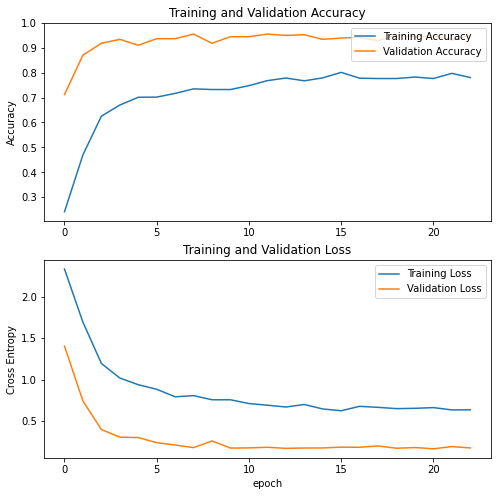

In [ ]:
# Plots des accuracy et cross entropy pour les sets de training et de validation par epoch
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# On récupère l'epoch aver la meilleure val_acc
val_acc_per_epoch = hist.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 8


## Fine Tuning

Essayons maintenant de Fine Tuner le modèle en reprenant l'entrainement à la meilleur epoch, mais en entrainant également les couches préentrainées avec un learning rate très faible.

In [ ]:
# Active l'entrainement des poids du modèle préentrainé
model.layers[0].trainable = True

# Définition de l'optimizer et du learning rate
opt = Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
%%time
# training
checkpoint = ModelCheckpoint("", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=10, 
                      verbose=1, 
                      mode='auto')

hist = model.fit(train_generator, 
                 validation_data=val_generator, 
                 epochs=50, 
                 callbacks=[checkpoint,early])

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 2.4461 - accuracy: 0.1981
Epoch 1: val_accuracy improved from -inf to 0.93140, saving model to 
INFO:tensorflow:Assets written to: assets
49/49 [==============================] - 57s 1s/step - loss: 2.4461 - accuracy: 0.1981 - val_loss: 0.2088 - val_accuracy: 0.9314
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 2.2989 - accuracy: 0.2052
Epoch 2: val_accuracy did not improve from 0.93140
49/49 [==============================] - 33s 672ms/step - loss: 2.2989 - accuracy: 0.2052 - val_loss: 0.3120 - val_accuracy: 0.9208
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 2.2046 - accuracy: 0.2338
Epoch 3: val_accuracy did not improve from 0.93140
49/49 [==============================] - 33s 663ms/step - loss: 2.2046 - accuracy: 0.2338 - val_loss: 0.4692 - val_accuracy: 0.9182
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 2.1597 - accuracy: 0.2610
Epoch 4: val_accu

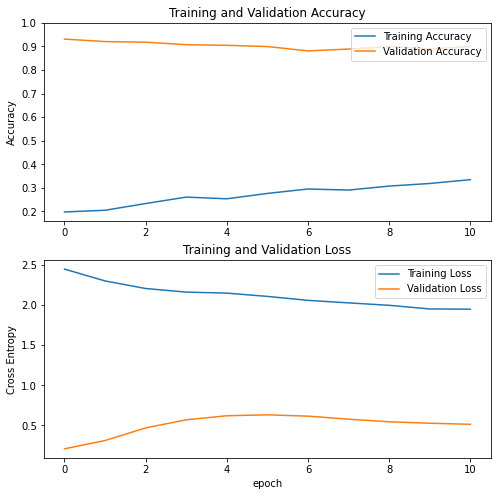

In [ ]:
# Plots des accuracy et cross entropy pour les sets de training et de validation par epoch
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Cela n'apporte pas de gains de performance. Au contraire, l'accuracy sur le set de validation diminue.

Tenons nous en donc au modèle dont seules les couches "additionnelles" ont étées entrainées avec le nombre d'epochs optimal et les meilleurs hyperparamètres trouvés.

# Prédiction de la classe d'une image

## Tests

In [ ]:
from keras.preprocessing import image
from keras.applications.xception import preprocess_input, decode_predictions
from PIL import Image

img_path = '/content/drive/My Drive/PStanford/data/images/Images/n02085620-Chihuahua/n02085620_3681.jpg'
model_path = "/content/drive/My Drive/PStanford/model_xception.h5"
img_size = 224

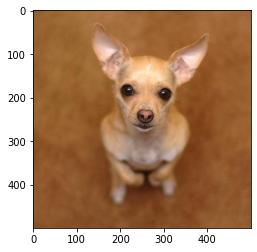

In [ ]:
# Affiche l'image en entrée
img_input = image.load_img(img_path)

plt.imshow(img_input)

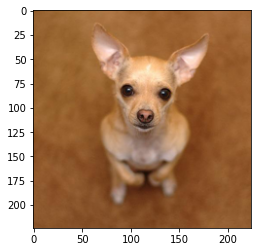

In [ ]:
# Affiche l'image redimensionnée
img = img_input.resize((224,224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = preprocess_input(img_tensor)

plt.imshow(img)

In [ ]:
# Charge le modèle
reconstructed_model = keras.models.load_model("/content/drive/My Drive/PStanford/model_xception.h5")

In [ ]:
# Calcule les probabilités pour chaque classe
probas = model.predict(img_tensor)

predicted_label = class_list[np.argmax(probas)]

In [ ]:
probas

array([[0.5395159 , 0.01829641, 0.03329456, 0.02124168, 0.0271243 ,
        0.01580887, 0.02609209, 0.27464238, 0.02186175, 0.0221221 ]],
      dtype=float32)

In [ ]:
# Numéro de la classe prédite
np.argmax(probas)

0

In [ ]:
# Label de la classe prédite
predicted_label

'n02085620-Chihuahua'

## Fonction de prédiction de la classe pour une image

Cette fonction permet de retourner la race de chien prédite depuis une image.

Cette même fonction est également dans le 2èm livrable (fichier .py retournant la race d'un chien depuis une image).

In [ ]:
from keras.preprocessing import image
from keras.applications.xception import preprocess_input, decode_predictions
from PIL import Image

img_path = '/content/drive/My Drive/PStanford/data/images/Images/n02085620-Chihuahua/n02085620_3681.jpg'
model_path = "/content/drive/My Drive/PStanford/model_xception.h5"
img_size = 224

In [ ]:
def get_predicted_label(img_path, model_path, class_list=None, img_size=224):
  """
  Prédit la race du chien sur l'image

  Args:
    img_path(string): path vers l'image

    model_path(string): path vers le modèle

    class_list(list): list des différentes races

    img_size(int): taille des côtés de l'image

  Returns:
    predicted_label
      - si class_list=None: predicted_label(int): le numero de la classe prédite
      - si class_list est renseigné: predicted_label(string) le label de la classe prédite
  """
  # Charge l'image
  img_input = image.load_img(img_path)

  # Resize l'image et convert en tensor
  img = img_input.resize((img_size,img_size))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor = preprocess_input(img_tensor)
  
  # Charge le modèle
  reconstructed_model = keras.models.load_model(model_path)

  # Calcule les probabilités de chaque classe
  probas = reconstructed_model.predict(img_tensor)

  # Détermine la classe ayant la plus grande probabilité
  if class_list is None:
    predicted_label = np.argmax(probas)

  else:
    predicted_label = class_list[np.argmax(probas)]

  return predicted_label

In [ ]:
# test de la fonction
get_predicted_label(img_path, model_path, class_list, img_size)

'n02085620-Chihuahua'